In [1]:

# Install dependencies 
# pip install opencv-python 
# %pip uninstall mediapipe -v



# Import packages

In [1]:
import mediapipe as mp
import cv2
import numpy as np
import os
import copy
import itertools
from collections import deque, Counter
import csv
import tensorflow as tf



# Initials MP Hands

In [2]:
mp_hands = mp.solutions.hands # hands model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

# Detecting Hands Function
A list of 21 hand landmarks on the left hand. Each landmark consists of x, y and z. x and y are normalized to [0.0, 1.0] by the image width and height respectively.

In [3]:
def mediapipe_detection(image, model):
    image = cv2.flip(image, 1)                     # Mirror display
    debug_image = copy.deepcopy(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results ,debug_image

# Drawing Landmarks

In [4]:
def draw_landmarkss(image, hand):
    # Draw Hand connections
    mp_drawing.draw_landmarks(image, hand, mp_hands.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(33, 225, 225), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(33, 225, 225), thickness=2, circle_radius=2),
                             )

In [5]:
def draw_bounding_rect(use_brect, image, brect):
    if use_brect:
        # Outer rectangle
        cv2.rectangle(image, (brect[0], brect[1]), (brect[2], brect[3]),
                     (0, 0, 0), 1)

    return image

In [6]:
def draw_info(image, mode, number):
    if 1 <= mode <= 2:
        cv2.putText(image, "Collecting Data ", (10, 90),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 1,
                   cv2.LINE_AA)
        if 0 <= number <= 9:
            cv2.putText(image, "NUM:" + str(number), (10, 110),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.6, (33, 225, 225), 1,
                       cv2.LINE_AA)
    return image


In [7]:
def draw_info_text(image, brect,finger_gesture_text):
    cv2.rectangle(image, (brect[0], brect[1]), (brect[2], brect[1] - 22),
                 (0, 0, 0), -1)
    
    # info_text = handedness.classification[0].label[0:]
        
    if finger_gesture_text != "":
        cv2.putText(image, "Hand Gesture:" + finger_gesture_text, (10, 60),
                   cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 0, 0), 4, cv2.LINE_AA)
        cv2.putText(image, "Hand Gesture:" + finger_gesture_text, (10, 60),
                   cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255, 255, 255), 2,
                   cv2.LINE_AA)
        # info_text = info_text + ':' + finger_gesture_text
    # cv2.putText(image, info_text, (brect[0] + 5, brect[1] - 4),
    #            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1, cv2.LINE_AA)

    return image

In [8]:
def draw_point_history(image, point_history):
    for index, point in enumerate(point_history):
        if point[0]!= 0 and point[1] != 0:
            cv2.circle(image, (point[0], point[1]), 1 + int(index / 2),
                      (152, 251, 152), 2)

    return image

# Read labels

In [9]:
actions = ['stop','goLeft', 'goRight', 'modeDiaPo','modeNormal']

# Draw The Rectangle Of Hand

In [10]:
def calc_bounding_rect(image, landmarks):
    image_width, image_height = image.shape[1], image.shape[0]

    landmark_array = np.empty((0, 2), int)

    for _, landmark in enumerate(landmarks.landmark):
        landmark_x = min(int(landmark.x * image_width), image_width - 1) 
        landmark_y = min(int(landmark.y * image_height), image_height - 1)

        landmark_point = [np.array((landmark_x, landmark_y))]

        landmark_array = np.append(landmark_array, landmark_point, axis=0)

    x, y, w, h = cv2.boundingRect(landmark_array)

    return [x, y, x + w, y + h] # retuen the coords of 4 points of the rect

# Extract Keypoint Values of Hand


In [11]:
# def calc_landmark_list(image, landmarks):
#     image_width, image_height = image.shape[1], image.shape[0]

#     landmark_point = []

#     # Keypoint
#     for _, landmark in enumerate(landmarks.landmark):
#         landmark_x = min(int(landmark.x * image_width), image_width - 1)
#         landmark_y = min(int(landmark.y * image_height), image_height - 1)

#         landmark_point.append([landmark_x, landmark_y])

#     return landmark_point # keypoint => [[x1,y1],[x2,y2]]

def calc_landmark_list(image, landmarks):
    image_width, image_height = image.shape[1], image.shape[0]

    landmark_point = []

    # キーポイント
    for _, landmark in enumerate(landmarks.landmark):
        landmark_x = min(int(landmark.x * image_width), image_width - 1)
        landmark_y = min(int(landmark.y * image_height), image_height - 1)
        # landmark_z = landmark.z

        landmark_point.append([landmark_x, landmark_y])

    return landmark_point

# Preprocess Data (Normalisation)

In our case  Coords

In [12]:
# def pre_process_Keypoint_history(image, Keypoints_history):
#     image_width, image_height = image.shape[1], image.shape[0]

#     temporarly_Keypoints_history = copy.deepcopy(Keypoints_history)

#     # Convert to relative coordinates
#     base_x, base_y = 0, 0
#     for index, point in enumerate(temporarly_Keypoints_history):
#         if index == 0:
#             base_x, base_y = point[0], point[1]
#            # point => [x,y]
#          # point => [x,y]

        
#         # Normalization of Coords
#         temporarly_Keypoints_history[index][0] = (temporarly_Keypoints_history[index][0] -
#                                         base_x) / image_width # x / image width
#         temporarly_Keypoints_history[index][1] = (temporarly_Keypoints_history[index][1] -
#                                         base_y) / image_height # y / image height

#     # Convert to a one-dimensional list (Flatten the temporarly_Keypoints_history list to 1d list )
#     temporarly_Keypoints_history = list(
#         itertools.chain.from_iterable(temporarly_Keypoints_history))

#     return temporarly_Keypoints_history

def pre_process_Keypoint_history(image, point_history):
    image_width, image_height = image.shape[1], image.shape[0]

    temp_point_history = copy.deepcopy(point_history)

    base_x, base_y = 0, 0
    for index, point in enumerate(temp_point_history):
        if index == 0:
            base_x, base_y = point[0], point[1]

        temp_point_history[index][0] = (temp_point_history[index][0] -
                                        base_x) / image_width
        temp_point_history[index][1] = (temp_point_history[index][1] -
                                        base_y) / image_height

    temp_point_history = list(
        itertools.chain.from_iterable(temp_point_history))

    return temp_point_history


In [14]:
def pre_process_landmark(landmark_list):
    temporarly_landmark_list = copy.deepcopy(landmark_list)

    # Convert to relative coordinates
    base_x, base_y = 0, 0
    for index, landmark_point in enumerate(temporarly_landmark_list):
        if index == 0:
            base_x, base_y = landmark_point[0], landmark_point[1]

        temporarly_landmark_list[index][0] = temporarly_landmark_list[index][0] - base_x
        temporarly_landmark_list[index][1] = temporarly_landmark_list[index][1] - base_y

    # Convert to a one-dimensional list
    temporarly_landmark_list = list(
        itertools.chain.from_iterable(temporarly_landmark_list))

    # Normalization
    max_value = max(list(map(abs, temporarly_landmark_list)))

    def normalize_(n):
        return n / max_value

    temporarly_landmark_list = list(map(normalize_, temporarly_landmark_list))

    return temporarly_landmark_list

# Save Collected Coords

In [15]:
def logging_csv(number, mode, point_history_list):
    if mode == 0:
        pass
    if mode == 2 and (0 <= number <= 9):
        csv_path = 'Gestures_Presentation_Controle_DataSet/Gesture_Keypoints.csv'
        with open(csv_path, 'a', newline="") as f:
            writer = csv.writer(f)
            writer.writerow([number, *point_history_list])
    return

# Choise of Mode

In [16]:
def select_mode(key, mode):
    number = -1
    if 48 <= key <= 57:  # 0 ~ 9
        number = key - 48
    if key == 110:  # n normal
        mode = 0
    if key == 104:  # h trainig frame
        mode = 2
    return number, mode

In [17]:
def draw_landmarks(image, landmark_point):
    # 接続線
    if len(landmark_point) > 0:
        # 親指
        cv2.line(image, tuple(landmark_point[2]), tuple(landmark_point[3]),
                (0, 0, 0), 6)
        cv2.line(image, tuple(landmark_point[2]), tuple(landmark_point[3]),
                (255, 255, 255), 2)
        cv2.line(image, tuple(landmark_point[3]), tuple(landmark_point[4]),
                (0, 0, 0), 6)
        cv2.line(image, tuple(landmark_point[3]), tuple(landmark_point[4]),
                (255, 255, 255), 2)

        # 人差指
        cv2.line(image, tuple(landmark_point[5]), tuple(landmark_point[6]),
                (0, 0, 0), 6)
        cv2.line(image, tuple(landmark_point[5]), tuple(landmark_point[6]),
                (255, 255, 255), 2)
        cv2.line(image, tuple(landmark_point[6]), tuple(landmark_point[7]),
                (0, 0, 0), 6)
        cv2.line(image, tuple(landmark_point[6]), tuple(landmark_point[7]),
                (255, 255, 255), 2)
        cv2.line(image, tuple(landmark_point[7]), tuple(landmark_point[8]),
                (0, 0, 0), 6)
        cv2.line(image, tuple(landmark_point[7]), tuple(landmark_point[8]),
                (255, 255, 255), 2)

        # 中指
        cv2.line(image, tuple(landmark_point[9]), tuple(landmark_point[10]),
                (0, 0, 0), 6)
        cv2.line(image, tuple(landmark_point[9]), tuple(landmark_point[10]),
                (255, 255, 255), 2)
        cv2.line(image, tuple(landmark_point[10]), tuple(landmark_point[11]),
                (0, 0, 0), 6)
        cv2.line(image, tuple(landmark_point[10]), tuple(landmark_point[11]),
                (255, 255, 255), 2)
        cv2.line(image, tuple(landmark_point[11]), tuple(landmark_point[12]),
                (0, 0, 0), 6)
        cv2.line(image, tuple(landmark_point[11]), tuple(landmark_point[12]),
                (255, 255, 255), 2)

        # 薬指
        cv2.line(image, tuple(landmark_point[13]), tuple(landmark_point[14]),
                (0, 0, 0), 6)
        cv2.line(image, tuple(landmark_point[13]), tuple(landmark_point[14]),
                (255, 255, 255), 2)
        cv2.line(image, tuple(landmark_point[14]), tuple(landmark_point[15]),
                (0, 0, 0), 6)
        cv2.line(image, tuple(landmark_point[14]), tuple(landmark_point[15]),
                (255, 255, 255), 2)
        cv2.line(image, tuple(landmark_point[15]), tuple(landmark_point[16]),
                (0, 0, 0), 6)
        cv2.line(image, tuple(landmark_point[15]), tuple(landmark_point[16]),
                (255, 255, 255), 2)

        # 小指
        cv2.line(image, tuple(landmark_point[17]), tuple(landmark_point[18]),
                (0, 0, 0), 6)
        cv2.line(image, tuple(landmark_point[17]), tuple(landmark_point[18]),
                (255, 255, 255), 2)
        cv2.line(image, tuple(landmark_point[18]), tuple(landmark_point[19]),
                (0, 0, 0), 6)
        cv2.line(image, tuple(landmark_point[18]), tuple(landmark_point[19]),
                (255, 255, 255), 2)
        cv2.line(image, tuple(landmark_point[19]), tuple(landmark_point[20]),
                (0, 0, 0), 6)
        cv2.line(image, tuple(landmark_point[19]), tuple(landmark_point[20]),
                (255, 255, 255), 2)

        # 手の平
        cv2.line(image, tuple(landmark_point[0]), tuple(landmark_point[1]),
                (0, 0, 0), 6)
        cv2.line(image, tuple(landmark_point[0]), tuple(landmark_point[1]),
                (255, 255, 255), 2)
        cv2.line(image, tuple(landmark_point[1]), tuple(landmark_point[2]),
                (0, 0, 0), 6)
        cv2.line(image, tuple(landmark_point[1]), tuple(landmark_point[2]),
                (255, 255, 255), 2)
        cv2.line(image, tuple(landmark_point[2]), tuple(landmark_point[5]),
                (0, 0, 0), 6)
        cv2.line(image, tuple(landmark_point[2]), tuple(landmark_point[5]),
                (255, 255, 255), 2)
        cv2.line(image, tuple(landmark_point[5]), tuple(landmark_point[9]),
                (0, 0, 0), 6)
        cv2.line(image, tuple(landmark_point[5]), tuple(landmark_point[9]),
                (255, 255, 255), 2)
        cv2.line(image, tuple(landmark_point[9]), tuple(landmark_point[13]),
                (0, 0, 0), 6)
        cv2.line(image, tuple(landmark_point[9]), tuple(landmark_point[13]),
                (255, 255, 255), 2)
        cv2.line(image, tuple(landmark_point[13]), tuple(landmark_point[17]),
                (0, 0, 0), 6)
        cv2.line(image, tuple(landmark_point[13]), tuple(landmark_point[17]),
                (255, 255, 255), 2)
        cv2.line(image, tuple(landmark_point[17]), tuple(landmark_point[0]),
                (0, 0, 0), 6)
        cv2.line(image, tuple(landmark_point[17]), tuple(landmark_point[0]),
                (255, 255, 255), 2)

    # キーポイント
    for index, landmark in enumerate(landmark_point):
        if index == 0:  # 手首1
            cv2.circle(image, (landmark[0], landmark[1]), 5, (255, 255, 255),
                      -1)
            cv2.circle(image, (landmark[0], landmark[1]), 5, (0, 0, 0), 1)
        if index == 1:  # 手首2
            cv2.circle(image, (landmark[0], landmark[1]), 5, (255, 255, 255),
                      -1)
            cv2.circle(image, (landmark[0], landmark[1]), 5, (0, 0, 0), 1)
        if index == 2:  # 親指：付け根
            cv2.circle(image, (landmark[0], landmark[1]), 5, (255, 255, 255),
                      -1)
            cv2.circle(image, (landmark[0], landmark[1]), 5, (0, 0, 0), 1)
        if index == 3:  # 親指：第1関節
            cv2.circle(image, (landmark[0], landmark[1]), 5, (255, 255, 255),
                      -1)
            cv2.circle(image, (landmark[0], landmark[1]), 5, (0, 0, 0), 1)
        if index == 4:  # 親指：指先
            cv2.circle(image, (landmark[0], landmark[1]), 8, (255, 255, 255),
                      -1)
            cv2.circle(image, (landmark[0], landmark[1]), 8, (0, 0, 0), 1)
        if index == 5:  # 人差指：付け根
            cv2.circle(image, (landmark[0], landmark[1]), 5, (255, 255, 255),
                      -1)
            cv2.circle(image, (landmark[0], landmark[1]), 5, (0, 0, 0), 1)
        if index == 6:  # 人差指：第2関節
            cv2.circle(image, (landmark[0], landmark[1]), 5, (255, 255, 255),
                      -1)
            cv2.circle(image, (landmark[0], landmark[1]), 5, (0, 0, 0), 1)
        if index == 7:  # 人差指：第1関節
            cv2.circle(image, (landmark[0], landmark[1]), 5, (255, 255, 255),
                      -1)
            cv2.circle(image, (landmark[0], landmark[1]), 5, (0, 0, 0), 1)
        if index == 8:  # 人差指：指先
            cv2.circle(image, (landmark[0], landmark[1]), 8, (255, 255, 255),
                      -1)
            cv2.circle(image, (landmark[0], landmark[1]), 8, (0, 0, 0), 1)
        if index == 9:  # 中指：付け根
            cv2.circle(image, (landmark[0], landmark[1]), 5, (255, 255, 255),
                      -1)
            cv2.circle(image, (landmark[0], landmark[1]), 5, (0, 0, 0), 1)
        if index == 10:  # 中指：第2関節
            cv2.circle(image, (landmark[0], landmark[1]), 5, (255, 255, 255),
                      -1)
            cv2.circle(image, (landmark[0], landmark[1]), 5, (0, 0, 0), 1)
        if index == 11:  # 中指：第1関節
            cv2.circle(image, (landmark[0], landmark[1]), 5, (255, 255, 255),
                      -1)
            cv2.circle(image, (landmark[0], landmark[1]), 5, (0, 0, 0), 1)
        if index == 12:  # 中指：指先
            cv2.circle(image, (landmark[0], landmark[1]), 8, (255, 255, 255),
                      -1)
            cv2.circle(image, (landmark[0], landmark[1]), 8, (0, 0, 0), 1)
        if index == 13:  # 薬指：付け根
            cv2.circle(image, (landmark[0], landmark[1]), 5, (255, 255, 255),
                      -1)
            cv2.circle(image, (landmark[0], landmark[1]), 5, (0, 0, 0), 1)
        if index == 14:  # 薬指：第2関節
            cv2.circle(image, (landmark[0], landmark[1]), 5, (255, 255, 255),
                      -1)
            cv2.circle(image, (landmark[0], landmark[1]), 5, (0, 0, 0), 1)
        if index == 15:  # 薬指：第1関節
            cv2.circle(image, (landmark[0], landmark[1]), 5, (255, 255, 255),
                      -1)
            cv2.circle(image, (landmark[0], landmark[1]), 5, (0, 0, 0), 1)
        if index == 16:  # 薬指：指先
            cv2.circle(image, (landmark[0], landmark[1]), 8, (255, 255, 255),
                      -1)
            cv2.circle(image, (landmark[0], landmark[1]), 8, (0, 0, 0), 1)
        if index == 17:  # 小指：付け根
            cv2.circle(image, (landmark[0], landmark[1]), 5, (255, 255, 255),
                      -1)
            cv2.circle(image, (landmark[0], landmark[1]), 5, (0, 0, 0), 1)
        if index == 18:  # 小指：第2関節
            cv2.circle(image, (landmark[0], landmark[1]), 5, (255, 255, 255),
                      -1)
            cv2.circle(image, (landmark[0], landmark[1]), 5, (0, 0, 0), 1)
        if index == 19:  # 小指：第1関節
            cv2.circle(image, (landmark[0], landmark[1]), 5, (255, 255, 255),
                      -1)
            cv2.circle(image, (landmark[0], landmark[1]), 5, (0, 0, 0), 1)
        if index == 20:  # 小指：指先
            cv2.circle(image, (landmark[0], landmark[1]), 8, (255, 255, 255),
                      -1)
            cv2.circle(image, (landmark[0], landmark[1]), 8, (0, 0, 0), 1)

    return image

# Classifier

In [18]:

class PoseClassifier(object):
    def __init__(
        self,
        model_path='Model/Sign_classifier_MetaData.tflite',
        num_threads=1,
    ):
        self.interpreter = tf.lite.Interpreter(model_path=model_path,
                                               num_threads=num_threads)

        self.interpreter.allocate_tensors()
        self.input_details = self.interpreter.get_input_details()
        self.output_details = self.interpreter.get_output_details()

    def __call__(
        self,
        landmark_list,
    ):
        input_details_tensor_index = self.input_details[0]['index']
        self.interpreter.set_tensor(
            input_details_tensor_index,
            np.array([landmark_list], dtype=np.float32))
        self.interpreter.invoke()

        output_details_tensor_index = self.output_details[0]['index']

        result = self.interpreter.get_tensor(output_details_tensor_index)

        result_index = np.argmax(np.squeeze(result))

        return result_index


Pose_classifier = PoseClassifier()


In [19]:

class Classifier(object):
    def __init__(
        self,
        model_path='Model/Gestures_classifier_MetaData.tflite',
        score_th=0.8,
        invalid_value=0,
        num_threads=1,
    ):
        self.interpreter = tf.lite.Interpreter(model_path=model_path,
                                               num_threads=num_threads)

        self.interpreter.allocate_tensors()
        self.input_details = self.interpreter.get_input_details()
        self.output_details = self.interpreter.get_output_details()

        self.score_th = score_th
        self.invalid_value = invalid_value

    def __call__(
        self,
        point_history,
    ):
        input_details_tensor_index = self.input_details[0]['index']
        self.interpreter.set_tensor(
            input_details_tensor_index,
            np.array([point_history], dtype=np.float32))
        self.interpreter.invoke()

        output_details_tensor_index = self.output_details[0]['index']

        result = self.interpreter.get_tensor(output_details_tensor_index)

        result_index = np.argmax(np.squeeze(result))

        if np.squeeze(result)[result_index] < self.score_th:
            result_index = self.invalid_value

        return result_index



keypoint_classifier = Classifier()



In [20]:
"""

from keras.models import load_model
model_save_path = 'Model/Gestures_classifier.h5'


def classifier_h5(pre_processed_Keypoints_list):
    model = load_model(model_save_path)
    predict_result = model.predict(np.expand_dims(pre_processed_Keypoints_list, axis=0))
    result_index = np.argmax(np.squeeze(predict_result))
    return result_index


"""

"\n\nfrom keras.models import load_model\nmodel_save_path = 'Model/Gestures_classifier.h5'\n\n\ndef classifier_h5(pre_processed_Keypoints_list):\n    model = load_model(model_save_path)\n    predict_result = model.predict(np.expand_dims(pre_processed_Keypoints_list, axis=0))\n    result_index = np.argmax(np.squeeze(predict_result))\n    return result_index\n\n\n"

In [21]:
# Parameters Initialisation 
history_length = 16 # lenght of list that takes max indexes of predections 
Keypoints_history = deque(maxlen=history_length)
Argmax_list = deque(maxlen=history_length)
mode = 2 #mode Normal 
use_boundary_recttangle = True
print(Argmax_list)


deque([], maxlen=16)


# Collect Data

In [22]:
"""
# Camera preparation
cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 960)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 540)

# Set mediapipe model
with mp_hands.Hands(min_detection_confidence=0.7, min_tracking_confidence=0.5, max_num_hands=1) as hands:

    while cap.isOpened():

        # Process Key (ESC: end)
        key = cv2.waitKey(10)
        if key == 27:  # ESC
            break

        number, mode = select_mode(key, mode)

        # Camera capture #####################################################
        ret, frame = cap.read()
        if not ret:
            break

        # Make detections
        image, results, debug_image = mediapipe_detection(frame, hands)
        ActionDetected = 0
        
        if results.multi_hand_landmarks:
            for hand_landmarks, handedness in zip(results.multi_hand_landmarks,
                                                  results.multi_handedness):
                
                if handedness.classification[0].label == "Right" :
                    # Bounding box calculation
                    brect = calc_bounding_rect(debug_image, hand_landmarks)

                    # Landmark calculation
                    landmark_list = calc_landmark_list(debug_image, hand_landmarks)

                    # Conversion to relative coordinates / normalized coordinates
                    pre_processed_landmark_list = pre_process_landmark(
                        landmark_list)
                    pre_processed_Keypoints_list = pre_process_Keypoint_history(
                        debug_image, Keypoints_history)
                    
                    Keypoints_history.append(landmark_list[8]) 

                    
                    logging_csv(number, mode,
                            pre_processed_Keypoints_list)
                    
                    # Drawing part
                    debug_image = draw_bounding_rect(
                        use_boundary_recttangle, debug_image, brect)
                    debug_image = draw_landmarks(debug_image, landmark_list)
                    debug_image = draw_info_text(
                        debug_image,
                        brect,
                        actions[ActionDetected],
                    )
        else:
            Keypoints_history.append([0, 0])

        # debug_image = draw_info(debug_image, mode, number)
        debug_image = draw_point_history(debug_image, Keypoints_history)

        # Screen reflection
        cv2.imshow('Hand Gesture Recognition', debug_image)


cap.release()

cv2.destroyAllWindows()
"""

'\n# Camera preparation\ncap = cv2.VideoCapture(0)\ncap.set(cv2.CAP_PROP_FRAME_WIDTH, 960)\ncap.set(cv2.CAP_PROP_FRAME_HEIGHT, 540)\n\n# Set mediapipe model\nwith mp_hands.Hands(min_detection_confidence=0.7, min_tracking_confidence=0.5, max_num_hands=1) as hands:\n\n    while cap.isOpened():\n\n        # Process Key (ESC: end)\n        key = cv2.waitKey(10)\n        if key == 27:  # ESC\n            break\n\n        number, mode = select_mode(key, mode)\n\n        # Camera capture #####################################################\n        ret, frame = cap.read()\n        if not ret:\n            break\n\n        # Make detections\n        image, results, debug_image = mediapipe_detection(frame, hands)\n        ActionDetected = 0\n        \n        if results.multi_hand_landmarks:\n            for hand_landmarks, handedness in zip(results.multi_hand_landmarks,\n                                                  results.multi_handedness):\n                \n                if handedne

# Live Stream

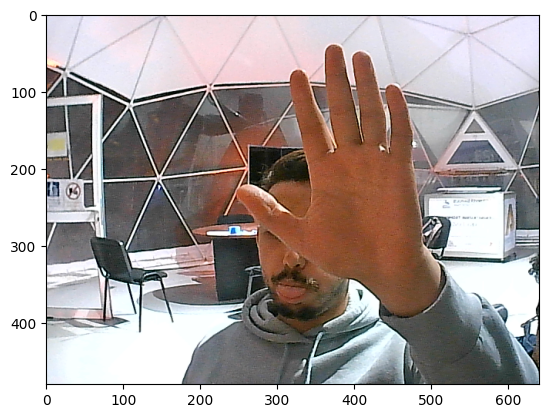

In [46]:
# Camera preparation
cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 960)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 540)
import matplotlib.pyplot as plt

# Set mediapipe model
with mp_hands.Hands(min_detection_confidence=0.7, min_tracking_confidence=0.5, max_num_hands=1) as hands:

    while cap.isOpened():

        # Process Key (ESC: end)
        key = cv2.waitKey(10)
        if key == 27:  # ESC
            break
        # number, mode = select_mode(key, mode)

        # Camera capture #####################################################
        ret, frame = cap.read()
        if not ret:
            break

        # Make detections
        image, results, debug_image = mediapipe_detection(frame, hands)
        ActionDetected = 0
        
        if results.multi_hand_landmarks:
            for hand_landmarks, handedness in zip(results.multi_hand_landmarks,
                                                  results.multi_handedness):
                
                if handedness.classification[0].label == "Right" :
                    # Bounding box calculation
                    brect = calc_bounding_rect(debug_image, hand_landmarks)

                    # Landmark calculation
                    landmark_list = calc_landmark_list(debug_image, hand_landmarks)

                    # Conversion to relative coordinates / normalized coordinates
                    pre_processed_landmark_list = pre_process_landmark(
                        landmark_list)
                    pre_processed_Keypoints_list = pre_process_Keypoint_history(
                        debug_image, Keypoints_history)

                    hand_id = Pose_classifier(pre_processed_landmark_list)

                    hand_sign_id = 0
                    hand_sign_len = len(pre_processed_Keypoints_list)

                    if hand_id in (0, 1):
                        landmark_index = 8 if hand_id == 0 else 12
                        Keypoints_history.append(landmark_list[landmark_index])
                    else:
                        Keypoints_history.append([0, 0])
                        
                    if hand_sign_len == (history_length * 2):
                        hand_sign_id = keypoint_classifier(
                            pre_processed_Keypoints_list)
                        
                    action_detected = [1, 2] if hand_id == 0 else [3, 4]
                    Argmax_list.append(hand_sign_id)
                    most_common_fg_id = Counter(
                        Argmax_list).most_common()
                    if most_common_fg_id[0][0] in action_detected:
                        ActionDetected = most_common_fg_id[0][0]
                        
                    # Drawing part
                    debug_image = draw_bounding_rect(
                        use_boundary_recttangle, debug_image, brect)
                    debug_image = draw_landmarks(debug_image, landmark_list)
                    debug_image = draw_info_text(
                        debug_image,
                        brect,
                        actions[ActionDetected],
                    )
        else:
            Keypoints_history.append([0, 0])

        # debug_image = draw_info(debug_image, mode, number)
        debug_image = draw_point_history(debug_image, Keypoints_history)

        # Screen reflection
        cv2.imshow('Hand Gesture Recognition', debug_image)

cap.release()

cv2.destroyAllWindows()

# Live Stream v2

In [ ]:
# Camera preparation
cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 960)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 540)

# Set mediapipe model
with mp_hands.Hands(min_detection_confidence=0.7, min_tracking_confidence=0.5, max_num_hands=1) as hands:

    while cap.isOpened():

        # Process Key (ESC: end)
        key = cv2.waitKey(10)
        if key == 27:  # ESC
            break
        # number, mode = select_mode(key, mode)

        # Camera capture #####################################################
        ret, frame = cap.read()
        if not ret:
            break

        # Make detections
        image, results, debug_image = mediapipe_detection(frame, hands)
        ActionDetected = 0
        
        if results.multi_hand_landmarks:
            for hand_landmarks, handedness in zip(results.multi_hand_landmarks,
                                                  results.multi_handedness):
                
                if handedness.classification[0].label == "Right" :
                    # Bounding box calculation
                    brect = calc_bounding_rect(debug_image, hand_landmarks)

                    # Landmark calculation
                    landmark_list = calc_landmark_list(debug_image, hand_landmarks)

                    # Conversion to relative coordinates / normalized coordinates
                    pre_processed_landmark_list = pre_process_landmark(
                        landmark_list)
                    pre_processed_Keypoints_list = pre_process_Keypoint_history(
                        debug_image, Keypoints_history)

                    hand_id = Pose_classifier(pre_processed_landmark_list)

                    hand_sign_id = 0
                    hand_sign_len = len(pre_processed_Keypoints_list)

                    if hand_id in (0, 1):
                        landmark_index = 8 if hand_id == 0 else 12
                        Keypoints_history.append(landmark_list[landmark_index])
                    else:
                        Keypoints_history.append([0, 0])
                        
                    if hand_sign_len == (history_length * 2):
                        hand_sign_id = keypoint_classifier(
                            pre_processed_Keypoints_list)
                        # print(hand_sign_id)
                        
                    action_detected = [1, 2] if hand_id == 0 else [3, 4]
                    Argmax_list.append(hand_sign_id)
                    print(Argmax_list)
                    most_common_fg_id = Counter(
                        Argmax_list).most_common()
                    if most_common_fg_id[0][0] in action_detected:
                        ActionDetected = most_common_fg_id[0][0]
                        print(actions[ActionDetected])

                    # Drawing part
                    debug_image = draw_bounding_rect(
                        use_boundary_recttangle, debug_image, brect)
                    debug_image = draw_landmarks(debug_image, landmark_list)
                    debug_image = draw_info_text(
                        debug_image,
                        brect,
                        actions[ActionDetected],
                    )
        else:
            Keypoints_history.append([0, 0])

        # debug_image = draw_info(debug_image, mode, number)
        debug_image = draw_point_history(debug_image, Keypoints_history)

        # Screen reflection
        cv2.imshow('Hand Gesture Recognition', debug_image)


cap.release()

cv2.destroyAllWindows()